In [1]:
pip install pyspark

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import *

In [6]:
spark = SparkSession.builder.appName('GooglePlayStoreAnalysis').getOrCreate()

In [11]:
from re import escape
df= spark.read.csv('googleplaystore.csv',header=True,inferSchema=True, sep = ',', escape = '"')

In [12]:
 df.count()

10841

In [14]:
df.show(1)

+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|      Genres|   Last Updated|Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M| 10,000+|Free|    0|      Everyone|Art & Design|January 7, 2018|      1.0.0|4.0.3 and up|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+-----------+------------+
only showing top 1 row



In [25]:
df = df.drop("size","Content Rating", "Last Updated","Current Ver", "Android Ver")

In [26]:
df.head()

Row(App='Photo Editor & Candy Camera & Grid & ScrapBook', Category='ART_AND_DESIGN', Rating=4.1, Reviews='159', Installs='10,000+', Type='Free', Price='0', Genres='Art & Design')

In [27]:
df.show()

+--------------------+--------------+------+-------+-----------+----+-----+--------------------+
|                 App|      Category|Rating|Reviews|   Installs|Type|Price|              Genres|
+--------------------+--------------+------+-------+-----------+----+-----+--------------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|    10,000+|Free|    0|        Art & Design|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|   500,000+|Free|    0|Art & Design;Pret...|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 5,000,000+|Free|    0|        Art & Design|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 215644|50,000,000+|Free|    0|        Art & Design|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|    967|   100,000+|Free|    0|Art & Design;Crea...|
|Paper flowers ins...|ART_AND_DESIGN|   4.4|    167|    50,000+|Free|    0|        Art & Design|
|Smoke Effect Phot...|ART_AND_DESIGN|   3.8|    178|    50,000+|Free|    0|        Art & Design|
|    Infinite Painter|ART_AND_

In [41]:
df = df.withColumn("Reviews", df["Reviews"].cast("int"))\
      .withColumn("Installs", regexp_replace("Installs", "[^0-9]", "").cast("int"))\
      .withColumn("Price", regexp_replace("Price", "[$]", "").cast("float"))

In [42]:
df.show()

+--------------------+-----------------+------+-------+--------+----+-----+--------------------+
|                 App|         Category|Rating|Reviews|Installs|Type|Price|              Genres|
+--------------------+-----------------+------+-------+--------+----+-----+--------------------+
|Ultimate F1 Racin...|AUTO_AND_VEHICLES|   3.8|    284|  100000|Free|  0.0|     Auto & Vehicles|
|DramaFever: Strea...|    ENTERTAINMENT|   4.2| 155234| 1000000|Free|  0.0|       Entertainment|
|Room planner: Int...|   HOUSE_AND_HOME|   4.0|   4281|  100000|Free|  0.0|        House & Home|
|Trulia Mortgage C...|   HOUSE_AND_HOME|   4.1|     81|   50000|Free|  0.0|        House & Home|
|Live 4D Results !...|        LIFESTYLE|   4.6| 116079| 5000000|Free|  0.0|           Lifestyle|
| Geometry Dash World|             GAME|   4.6| 760628|10000000|Free|  0.0|              Arcade|
|     Fallout Shelter|             GAME|   4.6|2719142|10000000|Free|  0.0|          Simulation|
|Best Fiends - Fre...|        

In [56]:
df.createOrReplaceTempView("googleplaystore")

**Top 10 apps with highest reviews**

In [90]:

sql_1= spark.sql("select App, sum(Reviews) from googleplaystore group by App order by sum(Reviews) DESC Limit 10  ")

In [91]:
sql_1.show()

+--------------------+------------+
|                 App|sum(Reviews)|
+--------------------+------------+
|           Instagram|   199664676|
|            Facebook|   156286514|
|      Subway Surfers|   138606606|
|  WhatsApp Messenger|   138228988|
|      Clash of Clans|   134667058|
|Messenger – Text ...|   113289425|
|    Candy Crush Saga|   112134492|
|         8 Ball Pool|    99386198|
|        Clash Royale|    92530298|
|            Snapchat|    68045010|
+--------------------+------------+



In [92]:
sql_pd = sql_1.toPandas()

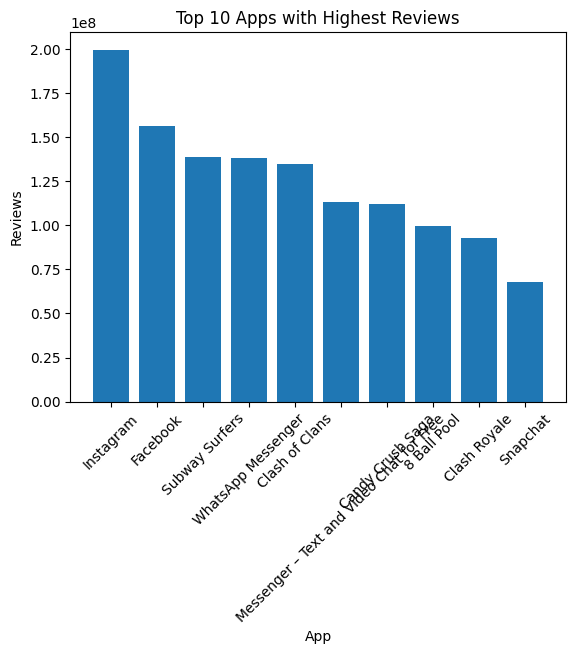

In [98]:
plt.bar(sql_pd['App'], sql_pd['sum(Reviews)'])
plt.xticks(rotation=45)
plt.xlabel('App')
plt.ylabel('Reviews')
plt.title('Top 10 Apps with Highest Reviews')
plt.show()

**Top 10 installed Apps**

In [77]:
sql_2 = spark.sql("select App, Type, sum(Installs) from googleplaystore group by App, Type order by sum(Installs) DESC Limit 10  ")
# Added 'Type' to the GROUP BY clause to include it in the grouping

In [78]:
sql_2.show()

+--------------------+----+-------------+
|                 App|Type|sum(Installs)|
+--------------------+----+-------------+
|      Subway Surfers|Free|   5000000000|
|            Hangouts|Free|   4000000000|
|       Google Photos|Free|   4000000000|
|           Instagram|Free|   3000000000|
|        Google Drive|Free|   3000000000|
|Google Chrome: Fa...|Free|   3000000000|
|Maps - Navigate &...|Free|   3000000000|
|         Google News|Free|   3000000000|
|        Temple Run 2|Free|   2500000000|
|    Candy Crush Saga|Free|   2500000000|
+--------------------+----+-------------+



In [102]:
sql_pd_2 = sql_2.toPandas()

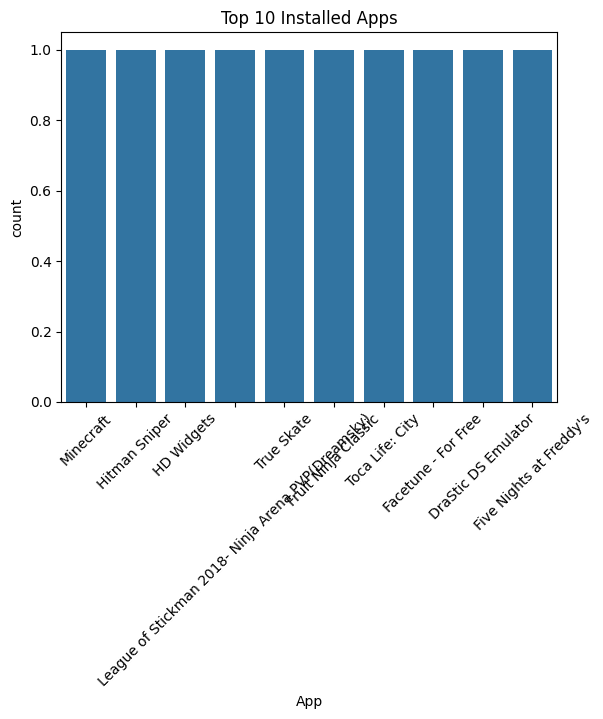

In [103]:
sns.countplot(data=sql_pd_2, x='App')
plt.xticks(rotation=45)
plt.title('Top 10 Installed Apps')
plt.show()

**top 10 Paid Apps **

In [82]:
sql_3 = spark.sql("select App, sum(Installs) from googleplaystore where Type = 'Paid' group by App order by sum(Installs) DESC Limit 10  ")


In [83]:
sql_3.show()

+--------------------+-------------+
|                 App|sum(Installs)|
+--------------------+-------------+
|           Minecraft|     20000000|
|       Hitman Sniper|     10000000|
|          HD Widgets|      2000000|
|League of Stickma...|      1000000|
|          True Skate|      1000000|
| Fruit Ninja Classic|      1000000|
|     Toca Life: City|      1000000|
| Facetune - For Free|      1000000|
| DraStic DS Emulator|      1000000|
|Five Nights at Fr...|      1000000|
+--------------------+-------------+



**Top Paid Rating apps**

In [85]:
sql_4 = spark.sql("select App, sum(Installs) from googleplaystore where Type = 'Paid' and Rating > 4.5 group by App order by sum(Installs) DESC Limit 10  ")

In [86]:
sql_4.show()

+--------------------+-------------+
|                 App|sum(Installs)|
+--------------------+-------------+
|       Hitman Sniper|     10000000|
|     Toca Life: City|      1000000|
| DraStic DS Emulator|      1000000|
|Five Nights at Fr...|      1000000|
|              Tasker|      1000000|
|   Where's My Water?|      1000000|
|   Cut the Rope GOLD|      1000000|
|         Bloons TD 5|      1000000|
|Cameringo+ Filter...|       500000|
|           Hitman GO|       500000|
+--------------------+-------------+



In [104]:
sql_4_pd = sql_4.toPandas()

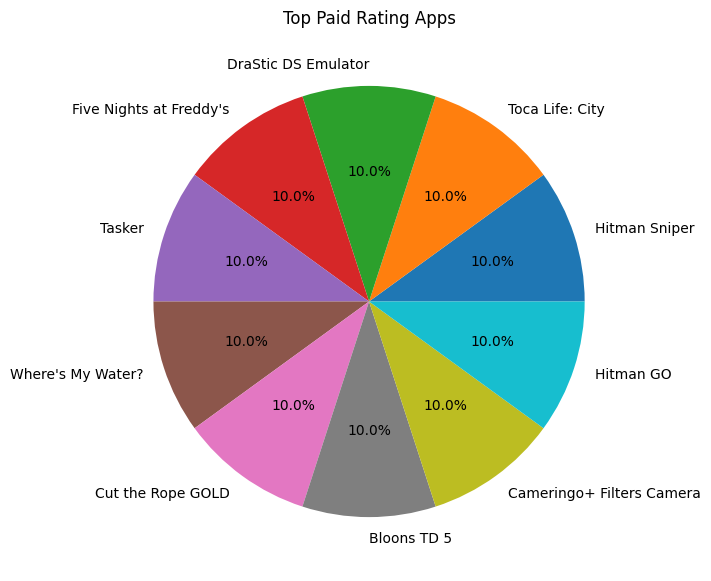

In [108]:
GroupedData = sql_4_pd['App'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(GroupedData, labels=GroupedData.index, autopct='%1.1f%%')
plt.title('Top Paid Rating Apps')
plt.show()
